**Problem Set #2**

Computational Electromagnetism and Applications (ΥΦΥ203)

Implemented by: **Anastasios-Faidon Retselis (AEM: 4394)**

# Exercise 2.1

Plot the fraction of the numerical to the analytical phase velocity (see slide 4-23 of S. Gedney) as a function of the angle of incidence $\theta$ for (a) $\Delta x = \Delta y = \lambda/10$ and (b) $\Delta x = \lambda/10,\; \Delta y = \lambda/20$. For both cases, choose the time step to be equal to 90% of the stability limit.

## Solution

The stability limit for the two-dimensional explicit equation is given by the following formula:

$$
\Delta t<\frac{1}{c \sqrt{\frac{1}{\Delta x^{2}}+\frac{1}{\Delta y^{2}}}}
$$

which can be further simplified if $\Delta x =\Delta y=\Delta$:

$$
\Delta t<\frac{\Delta}{c \sqrt{2}}
$$

and from these two equations we can calculate the desired time stop to be some percentage of the stability limit. 

From the dispersion relationship in discrete space:

$$
\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)-\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k}_{x} \Delta x}{2}\right)-\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k}_{y} \Delta y}{2}\right)=0
$$

we can substitute $\tilde{k}_{x}=\tilde{k}cos(\theta)$ and $\tilde{k}_{y}=\tilde{k}sin(\theta)$, leading to:

$$
\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)=\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k} \cos (\theta) \Delta x}{2}\right)+\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k} \sin (\theta) \Delta y}{2}\right)
$$

$\tilde{k}$ can be computed using Newton-Raphson's method $\tilde{k}_{i+1}=\tilde{k}_{i}-f\left(\tilde{k}_{i}\right) / f^{\prime}\left(\tilde{k}_{i}\right)$ which in this case can be rewritten as:

$$
\tilde{k}_{i+1}=\tilde{k}_{i}-\frac{\frac{1}{\Delta x^{2}} \sin ^{2}\left(\frac{\tilde{k}_{i} \cos (\theta) \Delta x}{2}\right)+\frac{1}{\Delta y^{2}} \sin ^{2}\left(\frac{\tilde{k}_{i} \sin (\theta) \Delta y}{2}\right)-\frac{1}{c^{2} \Delta t^{2}} \sin ^{2}\left(\frac{\omega \Delta t}{2}\right)}{\frac{\cos (\theta)}{2 \Delta x} \sin \left(\tilde{k}_{i} \cos (\theta) \Delta x\right)+\frac{\sin (\theta)}{2 \Delta y} \sin \left(\tilde{k}_{i} \sin (\theta) \Delta y\right)}
$$

We note that c values in the equation above are simplified (see the equation for the time step $\Delta t$. The numerical phase velocity is given by the following formula:

$$
v_{p}=\frac{\omega}{\tilde{k}}
$$

which can be rewritten as:

$$
\frac{v_{p}}{c}= \frac{2\pi}{\lambda \tilde{k}}
$$


We can then compute $\tilde{k}$ for different values of the angle of incidence $\theta$ and plot those values to create the desired numerical phase velocity diagram. This procedure has been performed for both of the desired cases in the script which can be found below:

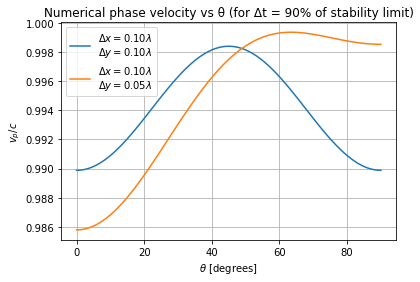

In [1]:
# Import script required packages
import numpy as np
import matplotlib.pyplot as plt
# Make jupyter export images as .pdf files for higher quality
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


def percent_stability_criterion(dx, dy, percent):
    # Computes a percent of the stability limit for the explicit 2D Formulation
    # Input: dx, dy, percent
    # Output: dt
    if dx == dy:
        dt = percent * dx / np.sqrt(2)
    else:
        dt = percent * 1 / (np.sqrt((1 / pow(dx, 2)) + (1 / pow(dy, 2))))
    return dt


def k_hat_newton(theta, dx, dy, dt, lambd):
    # Computes k_hat using the Newton-Raphson method
    # Input: theta [deg], dx, dy, dt, l
    # Output: k_hat
    theta = np.deg2rad(theta)
    # Define f and f dot
    f = lambda khat: ((1 / pow(dx, 2)) * pow(np.sin(khat * np.cos(theta) * dx / 2), 2)) + (
                (1 / pow(dy, 2)) * pow(np.sin(khat * np.sin(theta) * dy / 2), 2)) - (
                                 (1 / pow(dt, 2)) * pow(np.sin(np.pi * dt / lambd), 2))
    fdot = lambda khat: (np.cos(theta) / (2 * dx)) * np.sin(khat * np.cos(theta) * dx) + (
                np.sin(theta) / (2 * dy)) * np.sin(khat * np.sin(theta) * dy)
    # Stopping criteria
    n = 10  # Number of significant digits to be computed
    max_repetitions = 1000
    es = 0.5 * pow(10, (2 - n))  # Scarborough Criterion
    ea = 100
    k_prev = 2 * np.pi / lambd
    repetitions = 0
    # Main Newton-Raphson loop
    while ea > es:
        repetitions = repetitions + 1
        k_next = k_prev - (f(k_prev) / fdot(k_prev))
        ea = np.fabs((k_next - k_prev) * 100 / k_next)
        k_prev = k_next
        if repetitions > max_repetitions:
            print('Max repetitions reached without achieving desired accuracy for E!')
            break
    k_hat = k_next
    return k_hat


def phase_velocity_vs_theta_diagram(dx, dy, dt, lambd, min_theta, max_theta):
    # Creates a numerical phase velocity diagram vs theta for theta interval [min_theta, max_theta]
    # Input: dx, dy, dt, lambd, min_theta, max_theta
    # Output: None (can plot figure using plt.show())
    step_size = 1
    total_size = int(((max_theta - min_theta) / step_size) + 1)
    vpc_values = np.zeros(total_size)
    # Compute k and v_p/c values
    for i in range(0, total_size):
        theta = i * step_size
        k = k_hat_newton(theta, dx, dy, dt, lambd)
        vpc_values[i] = 2 * np.pi / (lambd * k)
    # Plot output
    plt.plot(vpc_values, label="$\Delta x = %.2f \lambda$\n$\Delta y = %.2f \lambda$" % (dx, dy))
    plt.title("Numerical phase velocity vs θ (for Δt = 90% of stability limit)")
    plt.ylabel(r"$v_{p}/c$")
    plt.xlabel(r"$\theta$ [degrees]")
    plt.legend()
    return None


theta_start = 0
theta_end = 90

# Case A: Delta_x = Delta_y = lambda/10, Delta_t = 0.9 C.L.
lmbd = 1
Delta_x = lmbd / 10
Delta_y = lmbd / 10
Delta_t = percent_stability_criterion(Delta_x, Delta_y, 0.9)
phase_velocity_vs_theta_diagram(Delta_x, Delta_y, Delta_t, lmbd, theta_start, theta_end)

# Case B: Delta_x = lambda/10, Delta_y = lambda/20, Delta_t = 0.9 C.L.
lmbd = 1
Delta_x = lmbd / 10
Delta_y = lmbd / 20
Delta_t = percent_stability_criterion(Delta_x, Delta_y, 0.9)
phase_velocity_vs_theta_diagram(Delta_x, Delta_y, Delta_t, lmbd, theta_start, theta_end)

# Show resulting plot
plt.grid()
plt.show()

# Exercise 2.2

For the attached program `fdtd2D_TEz.m` make the necessary changes (there are some parts for which you have to add some lines of code) and compute using a Fourier transformation the resonant frequencies for an empty cavity (see slides 4-39 of S. Gedney). What happens to these frequencies if a conducting cylinder is added in this cavity, by making the relevant changes to the code? (starting from line 100)

## Solution

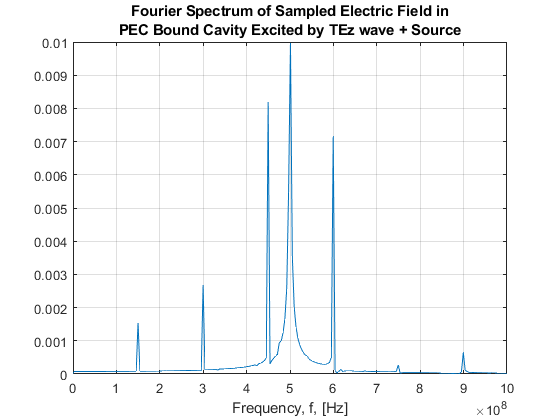

In [1]:
clear

%***********************************************************************
%     Fundamental constants
%***********************************************************************

cc=2.99792458e8;            %speed of light in free space
muz=4.0*pi*1.0e-7;          %permeability of free space
epsz=1.0/(cc*cc*muz);       %permittivity of free space

freq=500e+6;                %center frequency of source excitation
lambda=cc/freq;             %center wavelength of source excitation
omega=2.0*pi*freq;          

%***********************************************************************
%     Grid parameters
%***********************************************************************

ie=100;                 %number of grid cells in x-direction
je=100;                 %number of grid cells in y-direction

ib=ie+1;
jb=je+1;

is=40;                  %location of source
js=je/2;                %location of source

ir=15;                  %location of field recording
jr=15;                  %location of field recording

dx=0.01;                %space increment of square lattice
dy=0.01;
dt=0.99*dx/(sqrt(2.0)*cc);    %time step

nmax=10000;              %total number of time steps

%***********************************************************************
%     Material parameters
%     This is used for adding a lossy material in the cavity
%***********************************************************************

media=2;

%The first element corresponds to media 1 and the second to media 2:
eps=[1.0 1.0];         %relative electric permittivity
sig=[0.0 1.0e+7];      %electric conductivity (S/m)
mur=[1.0 1.0];         %relative permeability
sim=[0.0 0.0];         %equivalent magnetic loss (Ω/m)

%***********************************************************************
%     Wave excitation
%***********************************************************************

rtau=500.0e-9;
tau=rtau/dt;
delay=3*tau;

source=zeros(1,nmax);
for n=1:7.0*tau
  source(n)=sin(omega*(n-delay)*dt)*exp(-((n-delay)^2/tau^2));
end

%***********************************************************************
%     Field arrays
%***********************************************************************

ex=zeros(ie,jb);           %fields in main grid 
ey=zeros(ib,je);
hz=zeros(ie,je);
erec=zeros(1,nmax);

%***********************************************************************
%     Updating coefficients
%***********************************************************************

for i=1:media
  eaf  =dt*sig(i)/(2.0*epsz*eps(i));
  ca(i)=(1.0-eaf)/(1.0+eaf);
  cb(i)=dt/epsz/eps(i)/dx/(1.0+eaf);
  haf  =dt*sim(i)/(2.0*muz*mur(i));
  da(i)=(1.0-haf)/(1.0+haf);
  db(i)=dt/muz/mur(i)/dx/(1.0+haf);
end

%***********************************************************************
%     Geometry specification (main grid)
%***********************************************************************

%     Initialize entire main grid to free space

caex(1:ie,1:jb)=ca(1);     
cbex(1:ie,1:jb)=cb(1);

caey(1:ib,1:je)=ca(1);
cbey(1:ib,1:je)=cb(1);

dahz(1:ie,1:je)=da(1);
dbhz(1:ie,1:je)=db(1);

%***********************************************************************
%     BEGIN TIME-STEPPING LOOP
%***********************************************************************

for n=1:nmax

%***********************************************************************
%     Update electric fields (EX and EY) in main grid
%***********************************************************************

ex(:,2:je)=caex(:,2:je).*ex(:,2:je)+...
           cbex(:,2:je).*(hz(:,2:je)-hz(:,1:je-1));

ey(2:ie,:)=caey(2:ie,:).*ey(2:ie,:)+...
           cbey(2:ie,:).*(hz(1:ie-1,:)-hz(2:ie,:));
           
ey(is,2:je) = ey(is,2:je) + source(n)/dy;

field_recording(n) = ey(ir,jr);

%***********************************************************************
%     Update magnetic fields (HZ) in main grid
%***********************************************************************

hz(1:ie,1:je)=dahz(1:ie,1:je).*hz(1:ie,1:je)+... 
              dbhz(1:ie,1:je).*(ex(1:ie,2:jb)-ex(1:ie,1:je)+...
                                ey(1:ie,1:je)-ey(2:ib,1:je));


%***********************************************************************
%     END TIME-STEPPING LOOP
%***********************************************************************

end

Y = fft(field_recording);
Fs = 1/dt;
L = nmax;
P2 = abs(Y/L);
P1 = P2(1:L/2+1);
P1(2:end-1) = 2*P1(2:end-1);
f = Fs*(0:(L/2))/L;
%plot inline --format=svg
figure;
plot(f, P1);
xlim([0,1*10e8]);
xlabel('Frequency, f, [Hz]');
title({'Fourier Spectrum of Sampled Electric Field in',...
    'PEC Bound Cavity Excited by TEz wave + Source'});
grid on;

From the figure above, we can determine the frequencies for each cavity mode in order to check the FDTD approximation, as seen in the table below:

| Cavity Mode | Approximation (FDTD) |   Exact   |
|:-----------:|:--------------------:|:---------:|
|     $TE_{10}$    |       149.9 MHz      | 150.0 MHz |
|     $TE_{20}$    |       299.8 MHz      | 300.0 MHz |
|     $TE_{30}$    |       449.7 MHz      | 450.0 MHz |
|     $TE_{40}$    |       599.6 MHz      | 600.0 MHz |
|     $TE_{50}$    |       749.4 MHz      | 750.0 MHz |
|     $TE_{60}$    |       899.3 MHz      | 900.0 MHz |

We can also observe an extra peak at 501.1 MHz, which corresponds to the frequency of the source which we included in the program (500 MHz). In any case, we note that the resulting error is below 1%. Let us now include the conducting cylinder:

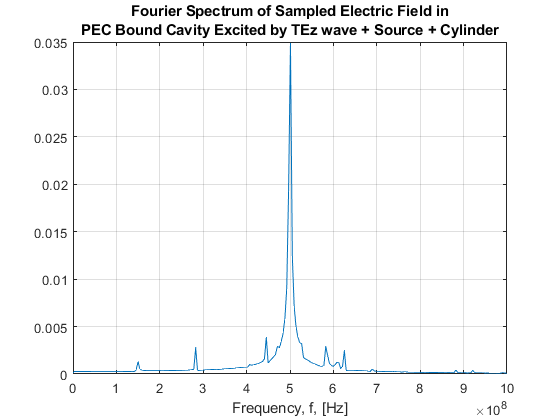

In [2]:
ex=zeros(ie,jb);           %fields in main grid 
ey=zeros(ib,je);
hz=zeros(ie,je);
erec=zeros(1,nmax);

%***********************************************************************
%     Updating coefficients
%***********************************************************************

for i=1:media
  eaf  =dt*sig(i)/(2.0*epsz*eps(i));
  ca(i)=(1.0-eaf)/(1.0+eaf);
  cb(i)=dt/epsz/eps(i)/dx/(1.0+eaf);
  haf  =dt*sim(i)/(2.0*muz*mur(i));
  da(i)=(1.0-haf)/(1.0+haf);
  db(i)=dt/muz/mur(i)/dx/(1.0+haf);
end

%***********************************************************************
%     Geometry specification (main grid)
%***********************************************************************

%     Initialize entire main grid to free space

caex(1:ie,1:jb)=ca(1);     
cbex(1:ie,1:jb)=cb(1);

caey(1:ib,1:je)=ca(1);
cbey(1:ib,1:je)=cb(1);

dahz(1:ie,1:je)=da(1);
dbhz(1:ie,1:je)=db(1);

%     Add cylinder made of medium 2

diam=20;          % diameter of cylinder
rad=diam/2.0;     % radius of cylinder
icenter=4*ie/5;   % i-coordinate of cylinder's center
jcenter=je/2;     % j-coordinate of cylinder's center

for i=1:ie
for j=1:je
  dist2=(i+0.5-icenter)^2 + (j-jcenter)^2;
  if dist2 <= rad^2 
     caex(i,j)=ca(2);
     cbex(i,j)=cb(2);
  end
  dist2=(i-icenter)^2 + (j+0.5-jcenter)^2;
  if dist2 <= rad^2 
     caey(i,j)=ca(2);
     cbey(i,j)=cb(2);
  end
end
end

%***********************************************************************
%     BEGIN TIME-STEPPING LOOP
%***********************************************************************

for n=1:nmax

%***********************************************************************
%     Update electric fields (EX and EY) in main grid
%***********************************************************************

ex(:,2:je)=caex(:,2:je).*ex(:,2:je)+...
           cbex(:,2:je).*(hz(:,2:je)-hz(:,1:je-1));

ey(2:ie,:)=caey(2:ie,:).*ey(2:ie,:)+...
           cbey(2:ie,:).*(hz(1:ie-1,:)-hz(2:ie,:));
           
%%% put one line here for the source, which extends in j = 2:je;
%ex(is,2:je) = ex(is,2:je) + source(n)/dx;
ey(is,2:je) = ey(is,2:je) + source(n)/dx;

%%% put one line here to record the field 
field_recording(n) = ey(ir,jr);

%***********************************************************************
%     Update magnetic fields (HZ) in main grid
%***********************************************************************

hz(1:ie,1:je)=dahz(1:ie,1:je).*hz(1:ie,1:je)+... 
              dbhz(1:ie,1:je).*(ex(1:ie,2:jb)-ex(1:ie,1:je)+...
                                ey(1:ie,1:je)-ey(2:ib,1:je));


%***********************************************************************
%     END TIME-STEPPING LOOP
%***********************************************************************

end

Y = fft(field_recording);
Fs = 1/dt;
L = nmax;
P2 = abs(Y/L);
P1 = P2(1:L/2+1);
P1(2:end-1) = 2*P1(2:end-1);
f = Fs*(0:(L/2))/L;
%plot inline --format=svg
figure;
plot(f, P1);
xlim([0,1*10e8]);
xlabel('Frequency, f, [Hz]');
title({'Fourier Spectrum of Sampled Electric Field in',...
    'PEC Bound Cavity Excited by TEz wave + Source + Cylinder'});
grid on;

We note that addition of the cylinder results to the resonant frequencies appearing at different and lower frequencies. We can also observe that the frequency of the source dominates the spectrum, having the highest amplitude among the different frequencies. 